BSD 2-Clause License

Copyright (c) 2024, Matthew Schaich
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [15]:
#Notes signed and dated by KD are debugging, any unsigned notes are from the BVH lab as part of the orignal 
#script -KD 2023.08.03

import matplotlib.pyplot as plt
import lumicks.pylake as lk
import itertools
import ipywidgets
import numpy as np
import glob
import os
import shutil
# We use skimage to downsample the data
from skimage.measure import block_reduce
from statistics import mean
from statistics import median
from scipy.stats import sem
#from matplotlib_venn import venn2 #this line is used for making venn diagrams of interactions
#if you get an error here just add in the terminal from the python environment: pip intall matplotlib-venn
%matplotlib inline
# Use notebook if you're in Jupyter Notebook
%matplotlib notebook
kymowidget = lk.KymoWidgetGreedy
#added here to try bypassing the above error from pylake wiki guessing probably an
#effect of depreciations -KD 2023.08.03

In [3]:
filename = glob.glob('*.h5') #fetches filename assuming only one .h5 in notebook
if len(filename) == 1:
    print (filename[0])
else: 
    print ("too many or too few .h5 files")
    print(len(filename))
file = lk.File(str(filename[0]))    
#adjusted original command in line 1 of this cell from filename = glob.glob('*.h5') to filename = glob.glob('**/*.h5')
#so glob.glob can find the h5 files in subdirectory -KD 2023.08.03

#adjusted this back temporarily but is a good trick! -- MS 2023-08-16

20231025-145240 Kymograph 15 d5.h5


In [4]:
forcex = file["Force HF"]["Force 1x"] #this cell downsamples the force to save memory and make it easier to visualize

# time traces (seconds)
time = forcex.timestamps/1e9
time = time - time[0]
sample_rate = forcex.sample_rate

downsampled_rate = 50 # Hz, this rate can be changed as needed

# downsample the force, nanostage position and time
forcex_downsamp = forcex.downsampled_by(int(sample_rate/downsampled_rate))
time_downsamp = forcex_downsamp.timestamps/1e9
time_downsamp = time_downsamp - time_downsamp[0]

median_force = (median(forcex_downsamp.data))

kymosname = [x for x in file.kymos.keys()]

#added with Sawyer's help where kymosname should be an object that matches list(file.kymos) as output from above
#but is a hashable type, prevents error I was getting in the next cell where kymosname has been placed -KD 2023.08.04

In [5]:
_, kymo = file.kymos.popitem() #after defining the downsample rate earlier, this actually does the downsampling

data = file.kymos[kymosname[0]].get_image(channel="blue")

#note this depends on the collection channel -- for Cy3 we use green -og comment on script
#adjusted value from file.kymos["11"] to value recognized, see cell above to use for debugging -KD 2023.08.04

downsample_factor = 1
data = block_reduce(data, (1, downsample_factor))
#rgb = kymo.rgb_image
kymo = file.kymos[kymosname[0]]

<IPython.core.display.Javascript object>


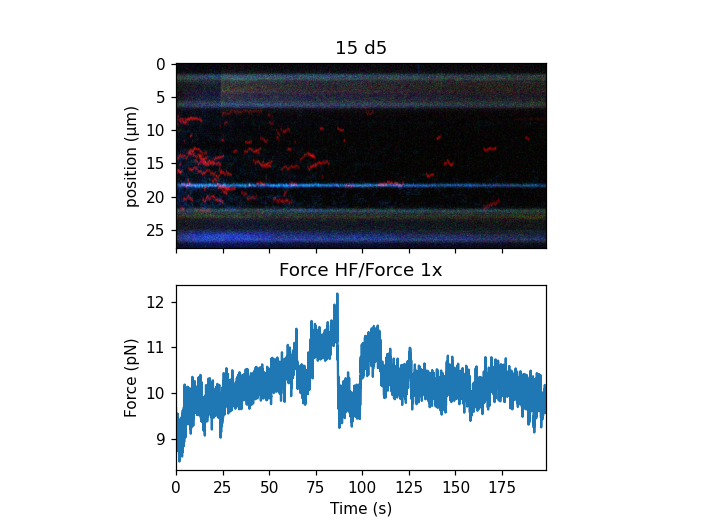

In [6]:
# define a color adjustment so we can see the data better
adjustment = lk.ColorAdjustment(0, 99.5, mode="percentile")

name, kymo = file.kymos.popitem()

kymo.plot_with_force("1x", "rgb", adjustment=adjustment, aspect_ratio=0.5)
plt.show()

In [7]:
pixel_size = kymo.pixelsize_um
pixel_size_int = pixel_size[0]

In [8]:
lk.KymoWidgetGreedy(kymo, 'rgb', aspect='auto', adjustment=adjustment,  min_length=4, pixel_threshold=5, window=7, sigma=1, vmax=2)
plt.show()
#this first plot is to look at the kymograph on the pixel scale in order to decide if an upper and lower bound need to be applied

In [9]:
crop_top = 8.2
crop_bottom = 23.4
#renamed these variables so that things run smoothly downstream -- MAS 9-6-23
adjusted_lower_bound = crop_top
adjusted_upper_bound = crop_bottom
steps_between_bounds = int((adjusted_upper_bound - adjusted_lower_bound) * 10) #defines number of 100 nm steps between bounds
downsample_factor = 1

kymo_crop = file.kymos[kymosname[0]].crop_by_distance(crop_top, crop_bottom)

#viewing the kymographs this way will show them after they are cropped
lk.KymoWidgetGreedy(kymo_crop, 'rgb', aspect='auto', adjustment=adjustment,  min_length=4, pixel_threshold=5, window=7, sigma=1, vmax=2)


In [10]:
#This cell for tracking lines with kymowidget greedy. It opens two views -- one with a fixed aspect ratio and one adjustable
#By saving and loading the lines as bluekymotracks.txt, they can easily be swapped back and forth between views as needed. Also used a scaling color map. MAS 9-6-23
blue_tracks = lk.KymoWidgetGreedy(kymo_crop.downsampled_by(downsample_factor), "blue", aspect="auto", min_length=4, pixel_threshold=1, window=12, sigma=0.25, vmax=6, correct_origin=True, cmap='viridis')

#I prefer the auto aspect so I just commented this one out for now.
#kymowidget1 = lk.KymoWidgetGreedy(kymo_crop.downsampled_by(downsample_factor), "blue", axis_aspect_ratio=2, min_length=4, pixel_threshold=1, window=7, sigma=0.25, vmax=2, correct_origin=True)

In [11]:
#Used this to replace the lines and save_lines functions below that have since been replaced with the 
#KymoTrackGroup tracks. Printed values should match, if they do not the analysis between the two is not the same.
#Be sure to load and save between the widgets, but ultimately kymowidget1, the 2nd one, is the one that I've
#chosen to export the .csv output required for further steps. The comma delimiter for the .csv is highly
#recommended as comma delimited .csv files can be opened with Excel -KD 2023.08.07


blue_tracks.save_tracks('kymotracks.csv', delimiter = ',')

In [12]:
#Replaced the above two obsolete cells with these commands containing updated, non-depreciated
#parameters -KD 2023.08.07

numberofbluelines=len(blue_tracks.tracks)
print(numberofbluelines)
numberofbluebins = int(round(np.sqrt (numberofbluelines)) )
print (numberofbluebins)

26
5


In [13]:
#This block exports the MSD plot for one line. More exports can be added as needed.
line0msd = blue_tracks.tracks[0].msd(max_lag=10000)
np.savetxt("line0msd.txt", 
           line0msd,
           delimiter =", ",
            fmt = "%s")

Happy tracking!